<a href="https://colab.research.google.com/github/jphall663/GWU_DNSC_6301_project/blob/main/DNSC_6301_Example_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### License

MIT License

Copyright (c) 2021 jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

#### Pythons imports

In [ ]:
from sklearn import tree                                  # sklearn tree model for decision trees
from sklearn.model_selection import train_test_split      # for partitioning data
from sklearn.model_selection import cross_val_score       # for cross validation
from sklearn.metrics import roc_auc_score, accuracy_score # to assess decision tree perforamce

# to upload local files
import io
from google.colab import files             

import numpy as np                                   # array, vector, matrix calculations
import pandas as pd                                  # dataFrame handling

from matplotlib import pyplot as plt                 # plotting
import seaborn as sns                                # slightly better plotting  

SEED = 12345                                         # ALWAYS use a random seed for better reproducibility

In [ ]:
# print version information 
import sys
import sklearn
version = ".".join(map(str, sys.version_info[:3]))
print('Python version:', version)
print('sklearn version:', sklearn.__version__)

Python version: 3.7.12
sklearn version: 0.22.2.post1


### Upload training data

In [ ]:
# special google collab command to upload a file from computer
uploaded = files.upload()

TypeError: ignored

In [ ]:
type(uploaded) # what kind of Python object did we just create?

dict

In [ ]:
uploaded.keys() # what is stored in that Python object?

dict_keys(['credit_line_increase.csv'])

In [ ]:
# read uploaded data into a pandas dataframe
data = pd.read_csv(io.StringIO(uploaded['credit_line_increase.csv'].decode('utf-8')))

#### Data Dictionary

| Name | Modeling Role | Measurement Level| Description|
| ---- | ------------- | ---------------- | ---------- |
|**ID**| ID | int | unique row indentifier |
| **LIMIT_BAL** | input | float | amount of previously awarded credit |
| **SEX** | demographic information | int | 1 = male; 2 = female
| **RACE** | demographic information | int | 1 = hispanic; 2 = black; 3 = white; 4 = asian |
| **EDUCATION** | demographic information | int | 1 = graduate school; 2 = university; 3 = high school; 4 = others |
| **MARRIAGE** | demographic information | int | 1 = married; 2 = single; 3 = others |
| **AGE** | demographic information | int | age in years |
| **PAY_0, PAY_2 - PAY_6** | inputs | int | history of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above |
| **BILL_AMT1 - BILL_AMT6** | inputs | float | amount of bill statement; BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005 |
| **PAY_AMT1 - PAY_AMT6** | inputs | float | amount of previous payment; PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005 |
| **DELINQ_NEXT**| target | int | whether a customer's next payment is delinquent (late), 1 = late; 0 = on-time |

#### Basic Data Analysis

In [ ]:
data.shape # (rows,columns)

(30000, 26)

In [ ]:
data.columns # names of columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DELINQ_NEXT'],
      dtype='object')

In [ ]:
data.isnull().any() # check for missing values

ID             False
LIMIT_BAL      False
SEX            False
RACE           False
EDUCATION      False
MARRIAGE       False
AGE            False
PAY_0          False
PAY_2          False
PAY_3          False
PAY_4          False
PAY_5          False
PAY_6          False
BILL_AMT1      False
BILL_AMT2      False
BILL_AMT3      False
BILL_AMT4      False
BILL_AMT5      False
BILL_AMT6      False
PAY_AMT1       False
PAY_AMT2       False
PAY_AMT3       False
PAY_AMT4       False
PAY_AMT5       False
PAY_AMT6       False
DELINQ_NEXT    False
dtype: bool

In [ ]:
data.describe() # basic descriptive statistics

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,2.721967,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,1.094397,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,2.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,3.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,4.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


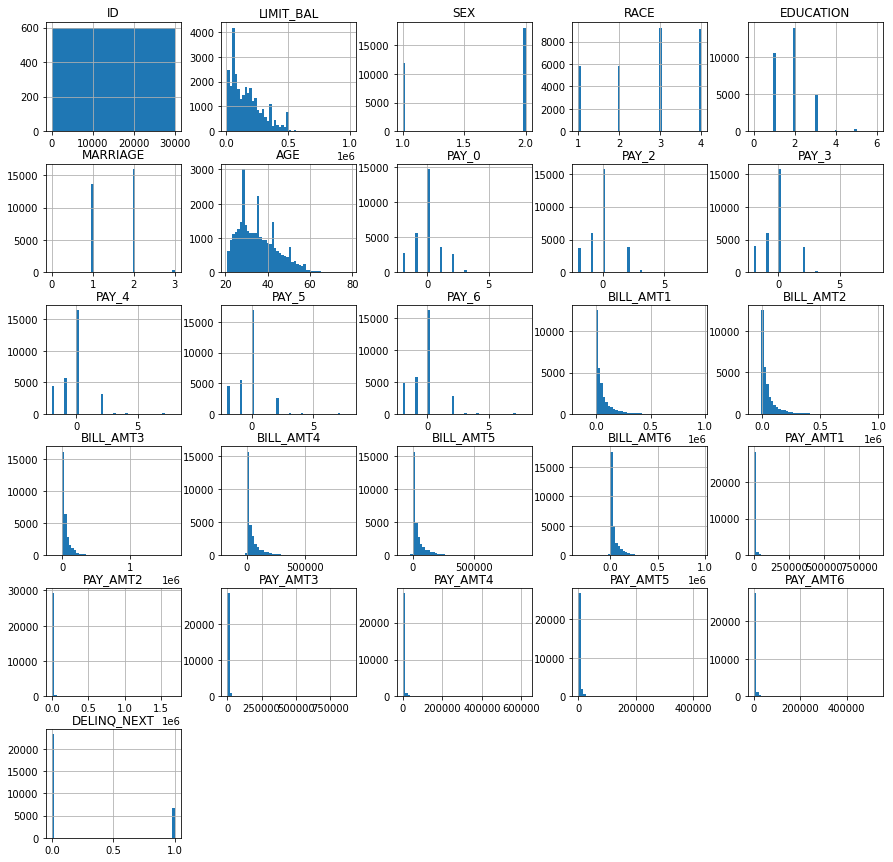

In [ ]:
_ = data[data.columns].hist(bins=50, figsize=(15, 15)) # display histograms

In [ ]:
# Pearson correlation matrix
corr = data.corr() 
corr

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
ID,1.000000,0.026179,0.018497,-0.000710,0.039177,-0.029079,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,-0.022199,-0.020270,0.019389,0.017982,0.024354,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952
LIMIT_BAL,0.026179,1.000000,0.024755,0.044173,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,-0.235195,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.018497,0.024755,1.000000,0.006149,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,-0.044008,-0.033642,-0.031183,-0.024563,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
RACE,-0.000710,0.044173,0.006149,1.000000,-0.012796,0.007010,0.001284,-0.102487,-0.082986,-0.074547,-0.072259,-0.067316,-0.054935,0.004232,0.002459,0.000543,0.000376,0.002096,0.002756,0.030069,0.012681,0.021854,0.026047,0.022148,0.020259,-0.303811
EDUCATION,0.039177,-0.219161,0.014232,-0.012796,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,0.082316,0.023581,0.018749,0.013002,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.029079,-0.108139,-0.031389,0.007010,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,0.034345,-0.023472,-0.021602,-0.024909,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.018678,0.144713,-0.090874,0.001284,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,-0.048773,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.030575,-0.271214,-0.057643,-0.102487,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.187068,0.189859,0.179785,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.011215,-0.296382,-0.070771,-0.082986,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.234887,0.235257,0.224146,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.018494,-0.286123,-0.066096,-0.074547,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.208473,0.237295,0.227494,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253


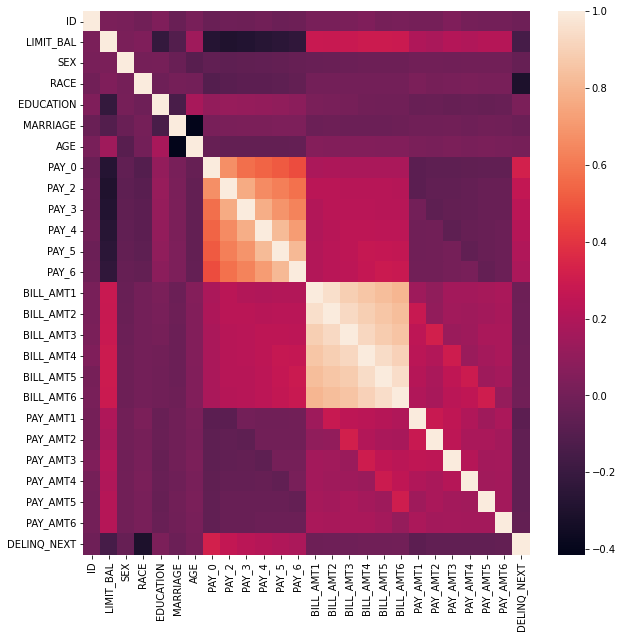

In [ ]:
# correlation heatmap
plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

#### Train decision tree 

In [ ]:
# assign basic modeling roles
# do not put demographic variables into a financial model!
y_name = 'DELINQ_NEXT'
X_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [ ]:
# partition data for honest assessment
train_X, valid_test_X, train_y, valid_test_y = train_test_split(data[X_names], data[y_name], test_size=0.5, random_state=SEED) # split off training data
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.5, random_state=SEED) # split remainder into validation and test

# summarize 
print('Training data: %i rows and %i columns' % (train_X.shape[0], train_X.shape[1] + 1))
print('Validation data: %i rows and %i columns' % (valid_X.shape[0], valid_X.shape[1] + 1))
print('Testing data: %i rows and %i columns' % (test_X.shape[0], test_X.shape[1] + 1))

# housekeeping
del valid_test_X 
del valid_test_y

Training data: 15000 rows and 20 columns
Validation data: 7500 rows and 20 columns
Testing data: 7500 rows and 20 columns


In [ ]:
# train decision tree 
max_depth = 15
candidate_models = {}
# with validation-based early stopping


In [ ]:
# plot tree depth vs. training and validation AUC
# using simple pandas plotting and matplotlib


In [ ]:
# veiw same results as a table, using pandas iloc to remove first column of table


In [ ]:
# plot the tree for human interpretation


In [ ]:
# plot variable importances
# create pandas dataframe
# plot dataframe values


In [ ]:
# score on test data for 
# final HONEST assessment
# this is not to see how well the model *did*!
# it's to get an assessment of how it *will do* on unseen data!


#### Function to create confusion matrices

In [ ]:
# function for confusion matrices


#### Function to calculate AIR

In [ ]:
# function for AIR


#### Bias testing

In [ ]:
# add probabilities onto validation set
# note we need a probability cutoff to make a final lending decision



In [ ]:
# calculate confusion matrices across race groups
# calculate confusion matrices at standard cutoff 0.15
# calculate AIR



In [ ]:
# calculate confusion matrices across sex groups
# calculate confusion matrices at standard cutoff 0.15
# calculate AIR 


#### Bias Remediation

In [ ]:
# function to calculate accuracy at a certain probability cutoff



In [ ]:
# observe accuracy trend as cutoff increases
# the problem is: higher cutoff means lending more money, even if more accurate


In [ ]:
# recalculate AIR and confusion matrices at different cutoff
      

In [ ]:
# redo model search with new information
# train decision tree 
# with validation-based early stopping
# and AIR calculation!



In [ ]:
# plot tree depth vs. training and validation AUC and AIR
# using simple pandas plotting and matplotlib

Turns out `depth=6` was a good choice for a final model!
* **Training AUC**: 0.78
* **Validation AUC**: 0.75
* **Test AUC**: 0.74
* **Asian-to-White AIR**: 1.00
* **Black-to-White AIR**: 0.85
* **Female-to-Male AIR**: 1.02
* **Hispanic-to-White AIR**: 0.83